In [1]:
import numpy as np
import xarray as xa
from astropy.io import fits
import tensorflow as tf
import tensorflow_probability as tfp
import pymaster as nmt
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt
from IPython import display
from began.visualization import mplot, plot

from pathlib import Path
import time
import yaml

import began
from began.logging import setup_vae_run_logging
from began import compute_apply_gradients
from began.xarray import resample, resample_iterations
from began import apply_per_image_standardization, apply_nmt_flat, make_square_mask, make_flat_bins, apply_l2min

%matplotlib inline
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
DATA_DIR = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp/data")
WRITE_DIR = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd")
PLOT_DIR = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd-exploration/plots")

PLOT_DIR.mkdir(exist_ok=True, parents=True)

ROOT_DIR = Path("/oasis/scratch/comet/bthorne/temp_project/began_scratch/mhd/mhd_temp")
CONFIG_DIR = Path("/home/bthorne/projects/gan/began/configs/training")

In [3]:
def load_cfg(cfg_path):
    with open(cfg_path) as f:
        cfg = yaml.load(f, Loader=yaml.FullLoader)
    return cfg['data'], cfg['training'], cfg['architecture'], Path(cfg['name'])

version = 29
model_name = f"mhd_temp_v{version}"

model_path = ROOT_DIR / "models" / f"{model_name}" / f"{model_name}.h5"
plot_dir =  ROOT_DIR / "plots"
data_dir = ROOT_DIR / "data"

data_cfg, train_cfg, architecture_cfg, name = load_cfg(CONFIG_DIR / "temp" / f"mhd_temp_v{version}.yaml")

In [4]:
model = began.CVAE(architecture_cfg['lat_dim'], architecture_cfg['inference_kernels'], architecture_cfg['generative_kernels'])
model.load_weights(str(model_path))

In [5]:
test_images = xa.open_dataarray(data_dir / data_cfg['test_file']).transpose('batch', ..., 'pol')

In [6]:
test_cl = xa.open_dataarray(data_dir / data_cfg['cl_train_file'])
test_cl_mean = test_cl.mean(dim='batch')
test_cl_std = test_cl.std(dim='batch')

In [7]:
nsamp = 100
dims = ['batch', 'x', 'y', 'pol']    
coords = {
    'batch': np.arange(nsamp),
    'x': np.arange(256),
    'y': np.arange(256),
    'pol': ['t']
}

samples = xa.DataArray(model.decode(np.random.randn(nsamp, architecture_cfg['lat_dim'])), coords=coords, dims=dims, name='Samples')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Latent Space Distribution

In [8]:
lat_mu, lat_std = model.encode(test_images.values)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Predictions

In [9]:
pred = model.predict(test_images.values)
pred_dset = test_images.copy()
pred_dset[...] = np.array(pred)

In [14]:
kwargs = {
    'vmin': 0.3, 
    'vmax': 0.7,
    'cmap': 'cividis',
    'robust': True, 
    'col': 'batch'
}

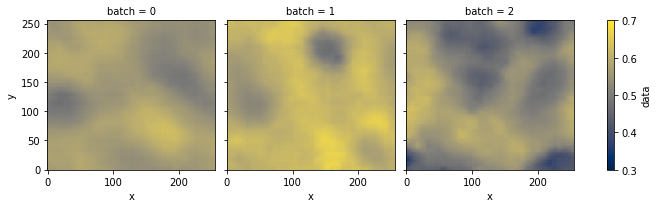

In [15]:
pred_dset.sel(batch=[1, 4, 5], pol='t').plot.pcolormesh('x', 'y', col_wrap=3, **kwargs)

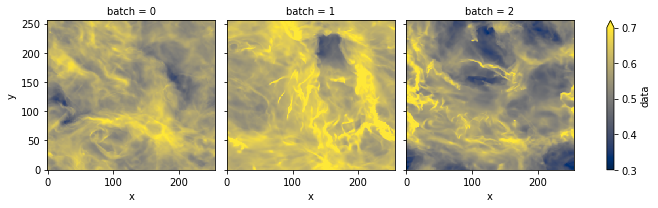

In [16]:
test_images.sel(batch=[1, 4, 5], pol='t').plot.pcolormesh('x', 'y', col_wrap=3,  **kwargs)

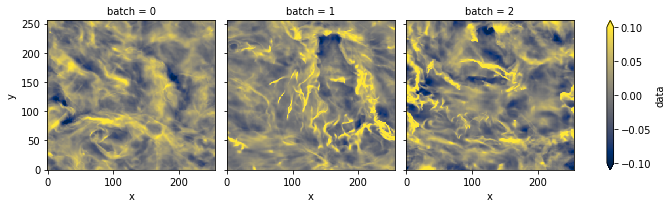

In [23]:
residuals = test_images - pred_dset
kwargs.update({'vmin':-0.1, 'vmax':0.1})
residuals.sel(batch=[1, 4, 5], pol='t').plot.pcolormesh('x', 'y', col_wrap=3, **kwargs)

# Histogram

In [28]:
bins = np.linspace(-2, 2, 50)
test_hist = histogram(test_images, bins=[bins], dim=['x', 'y'])
pred_hist = histogram(pred_dset, bins=[bins], dim=['x', 'y'])

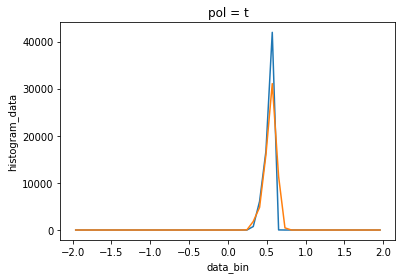

In [29]:
pred_hist.isel(batch=0, pol=0).plot()
test_hist.isel(batch=0, pol=0).plot()

In [30]:
resampled_test_images = resample_iterations(test_images, 50, dim='batch')
resampled_pred_images = resample_iterations(pred_dset, 50, dim='batch')

In [31]:
test_bin_iqr = histogram(resampled_test_images, bins=[bins], dim=['x', 'y']).median(dim='batch').quantile([0.25, 0.75], 'iteration').sel(pol='t')
pred_bin_iqr = histogram(resampled_pred_images, bins=[bins], dim=['x', 'y']).median(dim='batch').quantile([0.25, 0.75], 'iteration').sel(pol='t')

Text(0.5, 1.0, 'Interquartile range of pixel histogram')

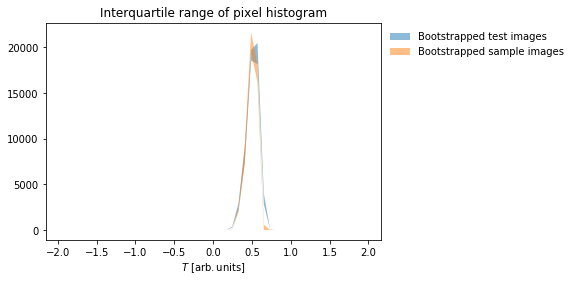

In [32]:
fig, ax = plt.subplots(1, 1)
ax.fill_between(test_bin_iqr.data_bin, test_bin_iqr.sel(quantile=0.25), test_bin_iqr.sel(quantile=0.75), label='Bootstrapped test images', alpha=0.5)
ax.fill_between(pred_bin_iqr.data_bin, pred_bin_iqr.sel(quantile=0.25), pred_bin_iqr.sel(quantile=0.75), label='Bootstrapped sample images', alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), frameon=False)
ax.set_label(r"Density")
ax.set_xlabel(r"$T~{\rm [arb. units]}$")
ax.set_title("Interquartile range of pixel histogram")

In [38]:
resampled_test_images = _resample_iterations(test_images, 50, dim='batch')
resampled_pred_images = _resample_iterations(samples, 50, dim='batch')

In [39]:
test_bin_iqr = histogram(resampled_test_images, bins=[bins], dim=['x', 'y']).median(dim='batch').quantile([0.25, 0.75], 'iteration').sel(pol='t')
pred_bin_iqr = histogram(resampled_pred_images, bins=[bins], dim=['x', 'y']).median(dim='batch').quantile([0.25, 0.75], 'iteration').sel(pol='t')

Text(0.5, 1.0, 'Interquartile range of pixel histogram')

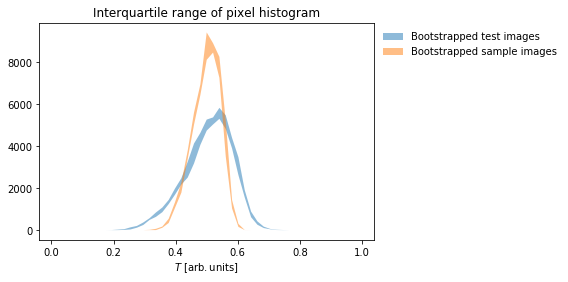

In [40]:
fig, ax = plt.subplots(1, 1)
ax.fill_between(test_bin_iqr.data_bin, test_bin_iqr.sel(quantile=0.25), test_bin_iqr.sel(quantile=0.75), label='Bootstrapped test images', alpha=0.5)
ax.fill_between(pred_bin_iqr.Samples_bin, pred_bin_iqr.sel(quantile=0.25), pred_bin_iqr.sel(quantile=0.75), label='Bootstrapped sample images', alpha=0.5)
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), frameon=False)
ax.set_label(r"Density")
ax.set_xlabel(r"$T~{\rm [arb. units]}$")
ax.set_title("Interquartile range of pixel histogram")

In [22]:
pred_bin_iqr


<xarray.DataArray 'histogram_Samples' (quantile: 2, Samples_bin: 49)>
array([[  21.5  ,   35.5  ,   57.5  ,   91.   ,  122.875,  171.125,
         233.   ,  312.625,  420.25 ,  533.5  ,  677.75 ,  863.   ,
        1069.5  , 1320.   , 1570.625, 1809.875, 2055.25 , 2259.   ,
        2504.   , 2734.   , 2948.5  , 3131.375, 3206.   , 3198.75 ,
        3276.5  , 3273.375, 3253.25 , 3120.5  , 2945.75 , 2713.125,
        2487.   , 2258.25 , 1987.   , 1707.5  , 1438.   , 1140.75 ,
         928.   ,  718.5  ,  536.5  ,  396.25 ,  288.   ,  200.875,
         136.875,   93.   ,   59.   ,   40.   ,   27.   ,   17.625,
          12.625],
       [  25.   ,   41.   ,   61.   ,   98.   ,  142.   ,  181.   ,
         253.375,  333.875,  435.75 ,  562.375,  692.   ,  877.   ,
        1115.25 , 1348.25 , 1599.75 , 1826.   , 2069.75 , 2292.5  ,
        2522.   , 2759.5  , 2993.25 , 3159.375, 3256.5  , 3277.   ,
        3334.5  , 3307.125, 3298.125, 3181.75 , 2976.5  , 2783.625,
        2527.   , 2273.5  , 2038.25 , 1743.   , 1467.   , 1177.625,
         948.875,  754.375,  572.375,  415.   ,  296.25 ,  224.   ,
         151.5  ,  106.   ,   66.   ,   47.375,   32.   ,   20.   ,
          13.   ]])
Coordinates:
    pol          <U1 't'
  * Samples_bin  (Samples_bin) float64 -1.959 -1.878 -1.796 ... 1.878 1.959
  * quantile     (quantile) float64 0.25 0.75

# Power spectrum

In [24]:
nx = 256
ny = 256
theta = 29.
ang = np.radians(theta)
mask = make_square_mask(nx, ny, ang, margin= 0.01)
binning = make_flat_bins(ang, nx, 15)
wsp00 = nmt.NmtWorkspaceFlat()
f0 = nmt.NmtFieldFlat(ang, ang, mask, np.random.randn(1, nx, nx))
wsp00.compute_coupling_matrix(f0, f0, binning)


In [25]:
pred_cl = apply_nmt_flat(pred_dset, mask, ang, binning, wsp00=wsp00)
pred_cl_mean = pred_cl.sel(field='tt').mean(dim='batch')
pred_cl_std = pred_cl.sel(field='tt').mean(dim='batch')

test_cl = apply_nmt_flat(test_images, mask, ang, binning, wsp00=wsp00)
test_cl_mean = test_cl.sel(field='tt').mean(dim='batch')
test_cl_std = test_cl.sel(field='tt').mean(dim='batch')

Text(0, 0.5, '$\\log[C_\\ell]$')

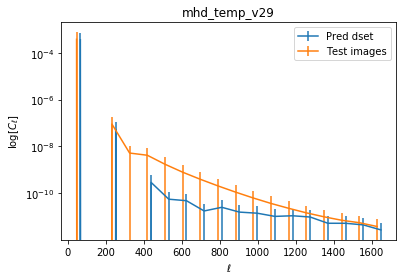

In [26]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'tt'
}
ax.set_title(f"{model_name}")
ax.errorbar(pred_cl.bandpowers+20, pred_cl_mean, yerr=pred_cl_std, label=f"Pred dset")
ax.errorbar(test_cl.bandpowers, test_cl_mean, yerr=test_cl_std, label=f"Test images")
#ax.errorbar(log_mean.bandpowers, train_spectra_mean.sel(**sel, direc='dn', zmin=200), yerr=train_spectra_std.sel(**sel, direc='dn', zmin=200), label=f"Training set")
ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\log[C_\ell]$")

No handles with labels found to put in legend.


Text(0, 0.5, '$\\log[C_\\ell]$')

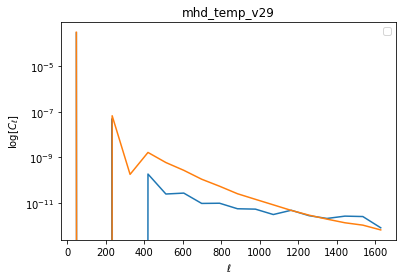

In [27]:
fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'tt',
    'batch': 50
}
ax.set_title(f"{model_name}")
ax.plot(pred_cl.bandpowers, pred_cl.sel(**sel))
ax.plot(test_cl.bandpowers, test_cl.sel(**sel))
#ax.errorbar(log_mean.bandpowers, train_spectra_mean.sel(**sel, direc='dn', zmin=200), yerr=train_spectra_std.sel(**sel, direc='dn', zmin=200), label=f"Training set")
ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\log[C_\ell]$")

Text(0, 0.5, '$\\log[C_\\ell]$')

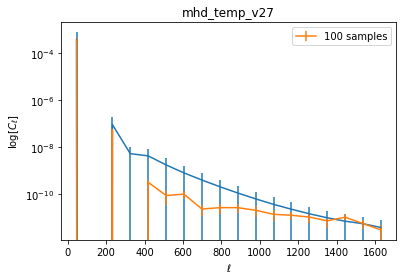

In [54]:
spectra = apply_nmt_flat(samples, mask, ang, binning, wsp00=wsp00)
mean = spectra.mean(dim='batch', skipna=True)
std = spectra.std(dim='batch', skipna=True)

fig, ax = plt.subplots(1, 1)
sel = {
    'field': 'tt'
}
ax.set_title(f"{model_name}")
ax.errorbar(test_cl_mean.bandpowers, test_cl_mean, yerr=test_cl_std)
ax.errorbar(mean.bandpowers, mean.sel(**sel), yerr=std.sel(**sel), label=f"{nsamp} samples")
#ax.errorbar(log_mean.bandpowers, train_spectra_mean.sel(**sel, direc='dn', zmin=200), yerr=train_spectra_std.sel(**sel, direc='dn', zmin=200), label=f"Training set")
ax.legend()
ax.set_yscale('log')
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\log[C_\ell]$")

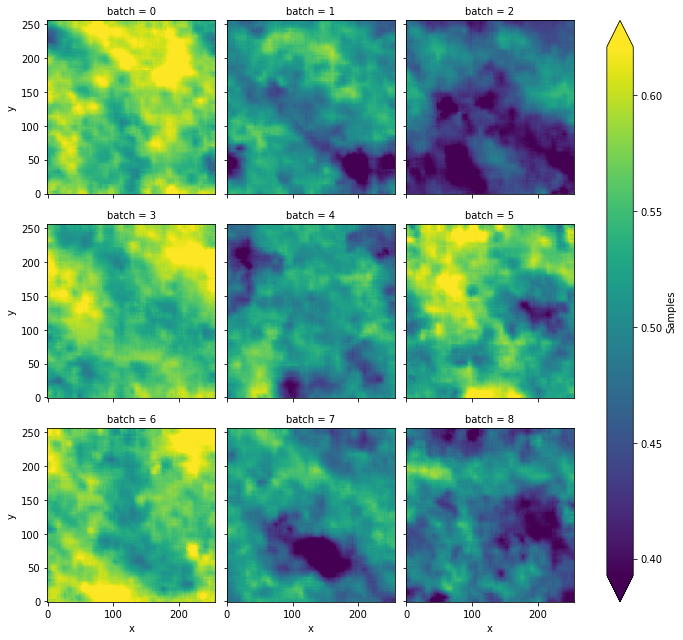

In [31]:
samples.sel(batch=np.arange(9), pol='t').plot(x='x', y='y', col='batch', col_wrap=3, robust=True)

In [82]:
dset['samples'].sample.size

100

# Comparison to test dataset

In [83]:
test_images = xa.open_dataarray(data_dir / data_cfg['test_file']).transpose('batch', ..., 'pol')
test_images

<xarray.DataArray 'data' (batch: 100, x: 256, y: 256, pol: 1)>
[6553600 values with dtype=float64]
Coordinates:
  * pol      (pol) object 't'
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 247 248 249 250 251 252 253 254 255
    zmin     (batch) int64 ...
    direc    (batch) object ...
    time     (batch) int64 ...
Dimensions without coordinates: batch

In [84]:
subsample_test = test_images.isel(batch=np.random.randint(0, test_images.batch.size, 3), pol=[0])

In [85]:
np.random.seed(None)
initial_position = tf.Variable(np.random.randn(1, architecture_cfg['lat_dim']).astype(np.float32))

In [86]:
pred_dset = apply_l2min(subsample_test, model, initial_position)
residuals = pred_dset - subsample_test

In [87]:
pred_dset

<xarray.DataArray 'data' (batch: 3, pol: 1, x: 256, y: 256)>
array([[[[0.13615677, 0.1451355 , 0.12779662, ..., 0.13593712,
          0.1077134 , 0.11311603],
         [0.15295343, 0.15073547, 0.13928767, ..., 0.13817221,
          0.10991485, 0.09369595],
         [0.14690952, 0.13921842, 0.13813534, ..., 0.13369592,
          0.12366384, 0.12974206],
         ...,
         [0.15568964, 0.16602579, 0.16700739, ..., 0.14607526,
          0.10660629, 0.10674277],
         [0.17525761, 0.1649381 , 0.16603395, ..., 0.1306529 ,
          0.09098445, 0.09541664],
         [0.16979437, 0.17135854, 0.1664781 , ..., 0.10695814,
          0.07968561, 0.09693699]]],


       [[[0.65306216, 0.64286315, 0.6540151 , ..., 0.6231948 ,
          0.623031  , 0.620023  ],
         [0.644765  , 0.6588672 , 0.66287374, ..., 0.6360254 ,
          0.62511486, 0.6252413 ],
         [0.66107345, 0.63140935, 0.6382392 , ..., 0.6280913 ,
          0.62563163, 0.62724656],
         ...,
         [0.6460074 , 0.6431523 , 0.6351186 , ..., 0.6908635 ,
          0.67283213, 0.66762036],
         [0.6283041 , 0.6289315 , 0.6144198 , ..., 0.67552507,
          0.6692635 , 0.6668515 ],
         [0.6308183 , 0.628126  , 0.6151242 , ..., 0.6730846 ,
          0.6678135 , 0.66512334]]],


       [[[0.48744938, 0.48808107, 0.48818514, ..., 0.60470176,
          0.5999798 , 0.5959581 ],
         [0.48969862, 0.48824173, 0.48912287, ..., 0.6140363 ,
          0.6037186 , 0.60244775],
         [0.48755863, 0.4883293 , 0.4831346 , ..., 0.59918135,
          0.6032756 , 0.5992692 ],
         ...,
         [0.51606756, 0.5165403 , 0.51730454, ..., 0.5497706 ,
          0.5411252 , 0.53779817],
         [0.51438457, 0.5168712 , 0.51850647, ..., 0.5618314 ,
          0.5549491 , 0.549589  ],
         [0.5147508 , 0.51571697, 0.5180423 , ..., 0.55889803,
          0.549839  , 0.5460691 ]]]], dtype=float32)
Coordinates:
    zmin     (batch) int64 100 100 100
    direc    (batch) object 'up' 'dn' 'up'
    time     (batch) int64 527 592 617
Dimensions without coordinates: batch, pol, x, y

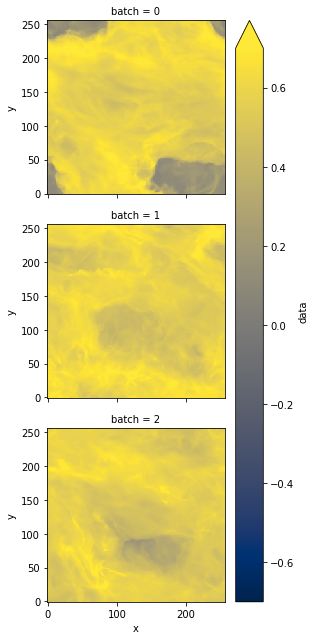

In [88]:
facet_grid = subsample_test.plot(x='x', y='y', row='batch', cmap='cividis', robust=True, vmin= -0.7, vmax=0.7)

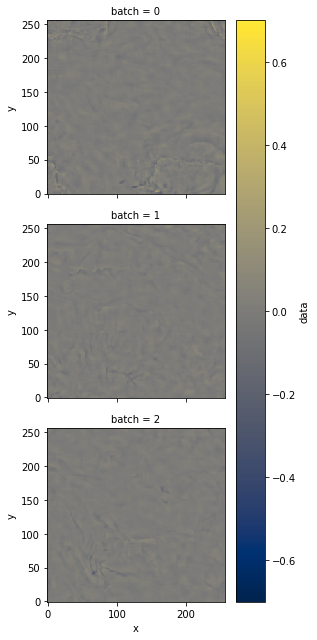

In [89]:
facet_grid = residuals.sel(pol='t').plot.pcolormesh('x', 'y', row='batch', cmap='cividis', robust=True, vmin= -0.7, vmax=0.7)

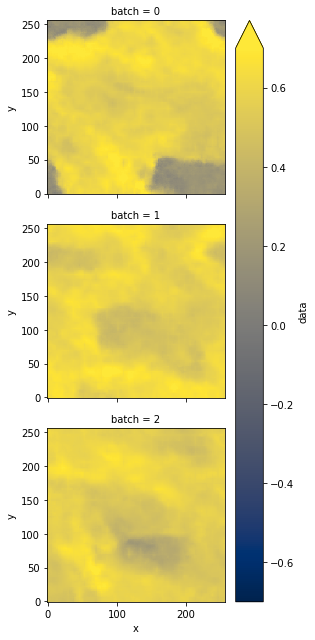

In [90]:
facet_grid = pred_dset.plot(x='x', y='y', row='batch', cmap='cividis', robust=True, vmin= -0.7, vmax=0.7)

In [91]:
test_dset_spectra = apply_nmt_flat(subsample_test, mask, ang, binning, wsp00=wsp00)
pred_spectra = apply_nmt_flat(pred_dset, mask, ang, binning, wsp00=wsp00)
res_spectra = apply_nmt_flat(residuals, mask, ang, binning, wsp00=wsp00)

In [92]:
test_dset_mean = test_dset_spectra.mean(dim=['batch'], skipna=True)
test_dset_std = test_dset_spectra.std(dim=['batch'], skipna=True)

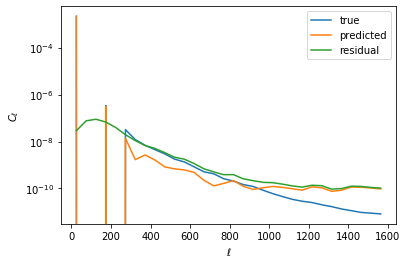

In [93]:
fig, ax = plt.subplots(1, 1)
ax.plot(test_dset_spectra.bandpowers, test_dset_spectra.isel(field=0, batch=0).values, label='true')
ax.plot(pred_spectra.bandpowers, pred_spectra.isel(field=0, batch=0).values, label='predicted')
ax.plot(res_spectra.bandpowers, res_spectra.isel(field=0, batch=0), label='residual')
ax.set_xlabel(r"$\ell$")
ax.set_yscale('log')
ax.set_ylabel(r"$C_\ell$")
ax.legend()

In [95]:
std_pred = apply_per_image_standardization(pred_dset)


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [96]:
std_dset = apply_per_image_standardization(subsample_test)

In [ ]:
facet_grid = pred_dset.plot(x='x', y='y', row='batch', cmap='cividis', robust=True, vmin= -0.7, vmax=0.7)

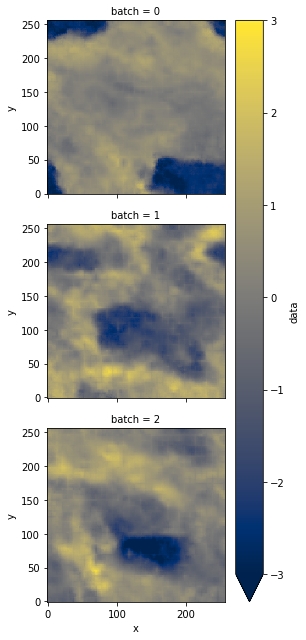

In [106]:
std_pred.plot(x='x', y='y', row='batch', cmap='cividis', robust=True, vmin=-3, vmax=3)

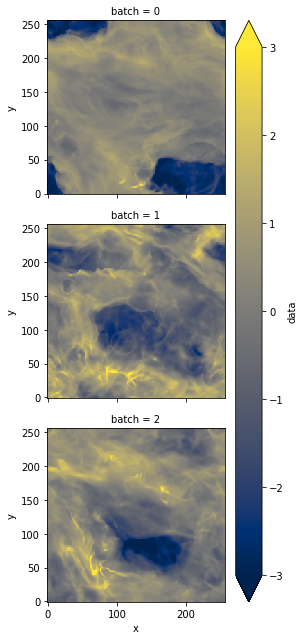

In [107]:
std_dset.plot(x='x', y='y', row='batch', cmap='cividis', robust=True, vmin=-3, vmax=3)

In [108]:
std_residuals = std_dset - std_pred

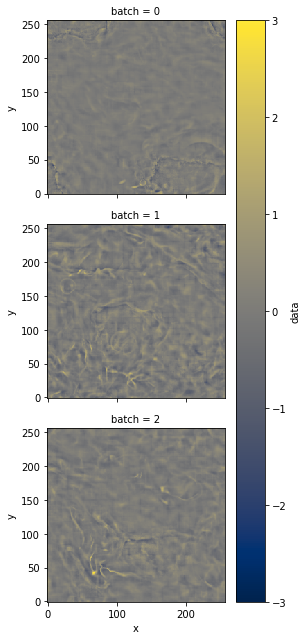

In [109]:
std_residuals.plot(x='x', y='y', row='batch', cmap='cividis', robust=True, vmin=-3, vmax=3)

In [128]:
arr = model.decode(model.encode(subsample_test.transpose('batch', ..., 'pol').values))

In [129]:
encoded = std_dset.transpose('batch', ..., 'pol').copy()

In [133]:
encoded[...] = arr
encoded = apply_per_image_standardization(encoded)

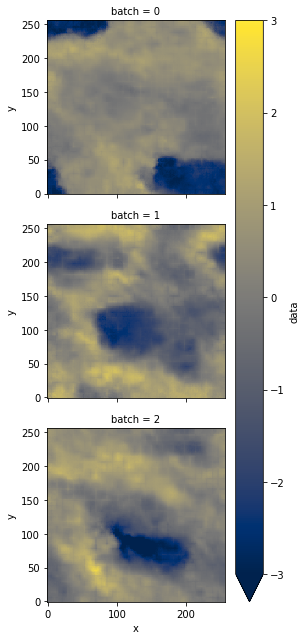

In [135]:
encoded.plot(x='x', y='y', row='batch', cmap='cividis', robust=True, vmin=-3, vmax=3)

<module 'pymaster' from '/home/bthorne/projects/gan/began/gpu-env/lib/python3.7/site-packages/pymaster/__init__.py'>